In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install eco2ai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.6/117.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 6.8 MB/s eta 0:00:00


In [3]:
import sys
# sys.path.append('E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/models/unet')

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

from utils import (
    save_checkpoint,
    load_checkpoint,
    get_loaders,
    check_accuracy,
    save_predictions_as_imgs,
    summarize_eco2ai_log,
    )

from model import UNET

from eco2ai import Tracker

from google.colab import files

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNET(in_channel=1, out_channel=1).to(device)
summary(model, input_size=(1, 256, 256), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 256, 256]             576
       BatchNorm2d-2         [32, 64, 256, 256]             128
              ReLU-3         [32, 64, 256, 256]               0
            Conv2d-4         [32, 64, 256, 256]          36,864
       BatchNorm2d-5         [32, 64, 256, 256]             128
              ReLU-6         [32, 64, 256, 256]               0
        DoubleConv-7         [32, 64, 256, 256]               0
         MaxPool2d-8         [32, 64, 128, 128]               0
            Conv2d-9        [32, 128, 128, 128]          73,728
      BatchNorm2d-10        [32, 128, 128, 128]             256
             ReLU-11        [32, 128, 128, 128]               0
           Conv2d-12        [32, 128, 128, 128]         147,456
      BatchNorm2d-13        [32, 128, 128, 128]             256
             ReLU-14        [32, 128, 1

In [5]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation.zip"
extract_path = "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted"

# Extract ZIP
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# List extracted files
os.listdir(extract_path)

['Modified_3_Brain_Tumor_Segmentation']

In [6]:
IMG_DIR      =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted/Modified_3_Brain_Tumor_Segmentation/images"
MASK_DIR     =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted/Modified_3_Brain_Tumor_Segmentation/masks"
VAL_IMG_DIR  =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted/Modified_3_Brain_Tumor_Segmentation/val_images"
VAL_MASK_DIR =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted/Modified_3_Brain_Tumor_Segmentation/val_masks"

In [7]:
Device = "cuda" if torch.cuda.is_available() else "cpu"
Learning_rate = 1e-3 # 1e-4 originally
Batch_size  = 32
num_epochs  = 30
num_workers = 4
IMAGE_HEIGHT = 256 # 512 originally
IMAGE_WIDTH  = 256 # 512 originally
PIN_MEMORY = True
LOAD_MODEL = False
CHECKPOINT_NAME = None

In [8]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    tracker = Tracker(
        project_name="U_Net_Training_Project",
        experiment_description="Training U_Net Model",
        file_name="U_Net_eco2ai_logs.csv",
        alpha_2_code="EG",
    )
    tracker.start()

    loop = tqdm(loader)
    running_loss=0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=Device)
        targets = targets.float().unsqueeze(1).to(device=Device)

        with torch.amp.autocast(device_type=Device):
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        running_loss+=loss.item()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=loss.item())

    tracker.stop()

    return running_loss/len(loader)

In [9]:
def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    model = UNET(in_channel=1, out_channel=1).to(Device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=Learning_rate)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    # scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    train_loader, val_loader = get_loaders(
        IMG_DIR,
        MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        Batch_size,
        train_transform,
        val_transform,
        num_workers,
        PIN_MEMORY,
    )

    train_losses=[]
    val_dice_scores=[]
    val_accs=[]

    if LOAD_MODEL:
        load_checkpoint(model=model, optimizer=optimizer, checkpoint_name=CHECKPOINT_NAME)
        check_accuracy(val_loader, model, device=Device)

    scaler = torch.amp.GradScaler()

    for epoch in range(num_epochs):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)
        if epoch!=0 and epoch%10==0:
            files.download("U_Net_eco2ai_logs.csv")

In [10]:
if __name__ == "__main__":
    main()

100%|██████████| 82/82 [01:02<00:00,  1.31it/s, loss=0.0381]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 82/82 [01:02<00:00,  1.31it/s, loss=0.0237]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 82/82 [01:03<00:00,  1.30it/s, loss=0.0276]


In [11]:
from google.colab import files

# Download the Eco2AI Logs
files.download("U_Net_eco2ai_logs.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Log loaded successfully.

🔍 Summary:
   🕒 Duration: 2193.36 seconds
   ⚡ Power Consumed: 0.0515 kWh
   🌱 CO₂ Emissions: 0.0242 kg


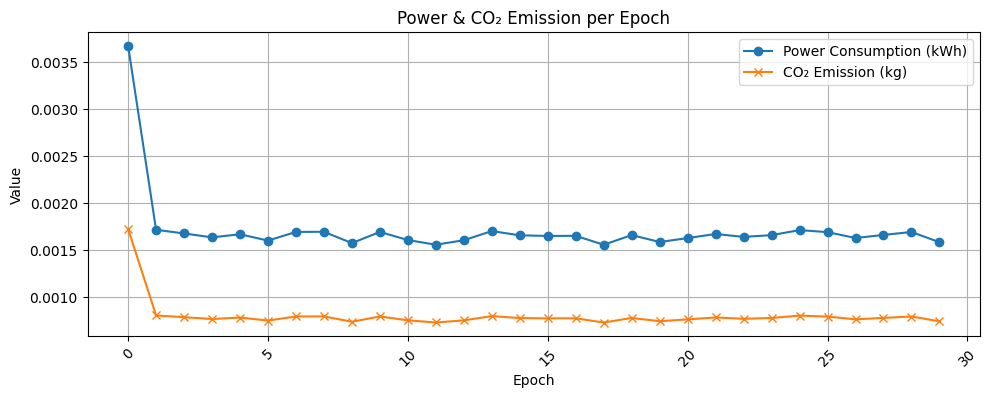

✅ Summary plot saved as 'U_Net_eco2ai_summary_plot.png'.


In [12]:
summarize_eco2ai_log("U_Net_eco2ai_logs.csv")

In [13]:
# Download the Eco2AI Plot
files.download("U_Net_eco2ai_summary_plot.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>